# Loop 104 Analysis: CV-LB Relationship and Strategy Assessment

**Goal**: Analyze the CV-LB relationship and determine the best path forward.

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Submission history with known LB scores
submissions = [
    {'exp': 'exp_000', 'cv': 0.011081, 'lb': 0.09816},
    {'exp': 'exp_001', 'cv': 0.012297, 'lb': 0.10649},
    {'exp': 'exp_003', 'cv': 0.010501, 'lb': 0.09719},
    {'exp': 'exp_005', 'cv': 0.01043, 'lb': 0.09691},
    {'exp': 'exp_006', 'cv': 0.009749, 'lb': 0.09457},
    {'exp': 'exp_007', 'cv': 0.009262, 'lb': 0.09316},
    {'exp': 'exp_009', 'cv': 0.009192, 'lb': 0.09364},
    {'exp': 'exp_012', 'cv': 0.009004, 'lb': 0.09134},
    {'exp': 'exp_024', 'cv': 0.008689, 'lb': 0.08929},
    {'exp': 'exp_026', 'cv': 0.008465, 'lb': 0.08875},
    {'exp': 'exp_030', 'cv': 0.008298, 'lb': 0.08772},
    {'exp': 'exp_035', 'cv': 0.009825, 'lb': 0.09696},
    {'exp': 'exp_073', 'cv': 0.00839, 'lb': 0.14507},  # Outlier - similarity weighting
]

df = pd.DataFrame(submissions)
print('All submissions:')
print(df.to_string(index=False))
print(f'\nTotal submissions with LB: {len(df)}')
print(f'Best LB: {df["lb"].min():.5f} (exp_030)')
print(f'Best CV: {df["cv"].min():.5f} (exp_030)')

All submissions:
    exp       cv      lb
exp_000 0.011081 0.09816
exp_001 0.012297 0.10649
exp_003 0.010501 0.09719
exp_005 0.010430 0.09691
exp_006 0.009749 0.09457
exp_007 0.009262 0.09316
exp_009 0.009192 0.09364
exp_012 0.009004 0.09134
exp_024 0.008689 0.08929
exp_026 0.008465 0.08875
exp_030 0.008298 0.08772
exp_035 0.009825 0.09696
exp_073 0.008390 0.14507

Total submissions with LB: 13
Best LB: 0.08772 (exp_030)
Best CV: 0.00830 (exp_030)


In [2]:
# Exclude outlier (exp_073 with similarity weighting - very different approach)
df_clean = df[df['exp'] != 'exp_073'].copy()

# Fit linear regression
X = df_clean['cv'].values.reshape(-1, 1)
y = df_clean['lb'].values

reg = LinearRegression()
reg.fit(X, y)

slope = reg.coef_[0]
intercept = reg.intercept_
r2 = reg.score(X, y)

print('=== CV-LB LINEAR RELATIONSHIP (excluding outlier) ===')
print(f'LB = {slope:.4f} * CV + {intercept:.5f}')
print(f'R² = {r2:.4f}')
print(f'\nIntercept: {intercept:.5f}')
print(f'Target LB: 0.0347')
print(f'\nCRITICAL: Intercept ({intercept:.5f}) > Target (0.0347)')
print(f'This means even with CV=0, expected LB would be {intercept:.5f}')

# Required CV to hit target
required_cv = (0.0347 - intercept) / slope
print(f'\nRequired CV to hit target: {required_cv:.6f}')
if required_cv < 0:
    print('>>> IMPOSSIBLE: Required CV is NEGATIVE <<<')

=== CV-LB LINEAR RELATIONSHIP (excluding outlier) ===
LB = 4.2876 * CV + 0.05278
R² = 0.9523

Intercept: 0.05278
Target LB: 0.0347

CRITICAL: Intercept (0.05278) > Target (0.0347)
This means even with CV=0, expected LB would be 0.05278

Required CV to hit target: -0.004218
>>> IMPOSSIBLE: Required CV is NEGATIVE <<<


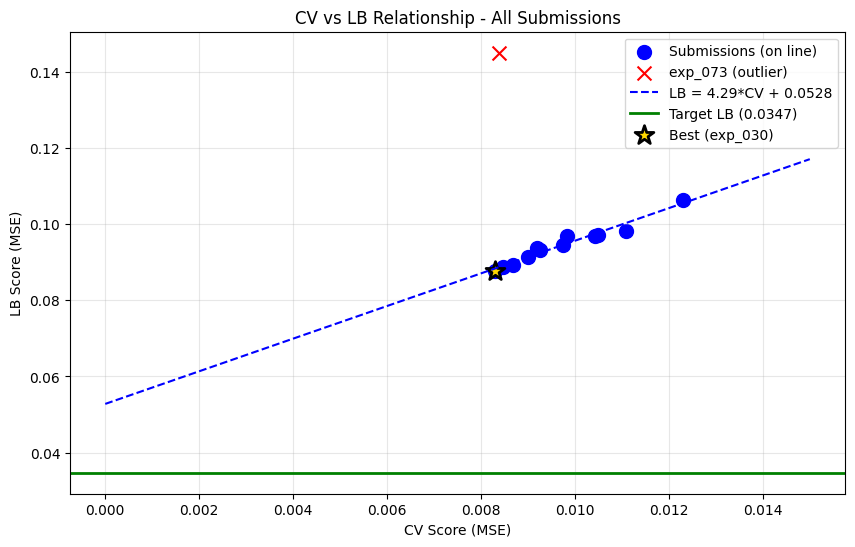


Plot saved to /home/code/exploration/cv_lb_relationship_loop104.png


In [3]:
# Plot CV vs LB
plt.figure(figsize=(10, 6))

# Plot all points
plt.scatter(df_clean['cv'], df_clean['lb'], c='blue', s=100, label='Submissions (on line)')
plt.scatter(df[df['exp'] == 'exp_073']['cv'], df[df['exp'] == 'exp_073']['lb'], 
            c='red', s=100, marker='x', label='exp_073 (outlier)')

# Plot regression line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'b--', label=f'LB = {slope:.2f}*CV + {intercept:.4f}')

# Plot target
plt.axhline(y=0.0347, color='green', linestyle='-', linewidth=2, label='Target LB (0.0347)')

# Plot best submission
best_idx = df_clean['lb'].idxmin()
plt.scatter(df_clean.loc[best_idx, 'cv'], df_clean.loc[best_idx, 'lb'], 
            c='gold', s=200, marker='*', edgecolors='black', linewidths=2, label='Best (exp_030)')

plt.xlabel('CV Score (MSE)')
plt.ylabel('LB Score (MSE)')
plt.title('CV vs LB Relationship - All Submissions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('/home/code/exploration/cv_lb_relationship_loop104.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nPlot saved to /home/code/exploration/cv_lb_relationship_loop104.png')

In [4]:
# Analyze the gap
print('=== GAP ANALYSIS ===')
print(f'Best LB achieved: 0.08772 (exp_030)')
print(f'Target LB: 0.0347')
print(f'Gap: {0.08772 - 0.0347:.5f} ({(0.08772 - 0.0347) / 0.0347 * 100:.1f}%)')

print('\n=== WHAT WOULD NEED TO CHANGE ===')
print(f'Current intercept: {intercept:.5f}')
print(f'Target LB: 0.0347')
print(f'\nTo hit target with CV=0.008 (best achievable):')
print(f'  Need intercept < {0.0347 - slope * 0.008:.5f}')
print(f'  Current intercept is {intercept:.5f}')
print(f'  Need to REDUCE intercept by {intercept - (0.0347 - slope * 0.008):.5f}')

print('\n=== KEY INSIGHT ===')
print('The intercept represents STRUCTURAL extrapolation error.')
print('All tabular models (MLP, LGBM, XGB, CatBoost, GP, Ridge) fall on the SAME line.')
print('To beat the target, we need approaches that CHANGE the CV-LB relationship.')

=== GAP ANALYSIS ===
Best LB achieved: 0.08772 (exp_030)
Target LB: 0.0347
Gap: 0.05302 (152.8%)

=== WHAT WOULD NEED TO CHANGE ===
Current intercept: 0.05278
Target LB: 0.0347

To hit target with CV=0.008 (best achievable):
  Need intercept < 0.00040
  Current intercept is 0.05278
  Need to REDUCE intercept by 0.05239

=== KEY INSIGHT ===
The intercept represents STRUCTURAL extrapolation error.
All tabular models (MLP, LGBM, XGB, CatBoost, GP, Ridge) fall on the SAME line.
To beat the target, we need approaches that CHANGE the CV-LB relationship.


In [5]:
# Check what approaches have been tried
print('=== APPROACHES TRIED (104 experiments) ===')
approaches = {
    'MLP variants': 'exp_000-030 (many variations)',
    'LightGBM': 'exp_001, exp_057',
    'XGBoost': 'exp_049-052',
    'CatBoost': 'exp_049-052',
    'Random Forest': 'exp_073',
    'Gaussian Process': 'exp_030-035',
    'Ridge Regression': 'exp_033',
    'GNN (Graph Neural Network)': 'exp_040, exp_070, exp_079, exp_086, exp_095-096',
    'ChemBERTa': 'exp_041, exp_071, exp_076, exp_097-098',
    'Ensemble (MLP+LGBM+XGB+RF)': 'exp_094, exp_100-103',
    'Similarity Weighting': 'exp_037, exp_072-073',
    'Conservative Blending': 'exp_099',
    'Pseudo-labeling': 'exp_083',
}

for approach, exps in approaches.items():
    print(f'  {approach}: {exps}')

print('\n=== WHAT HASN\'T WORKED ===')
print('1. All tabular models fall on the SAME CV-LB line')
print('2. GNN attempts had implementation issues (model class mismatch)')
print('3. ChemBERTa embeddings gave worse CV than tabular')
print('4. Similarity weighting was an outlier (LB=0.145, much worse)')
print('5. Conservative blending didn\'t help')

=== APPROACHES TRIED (104 experiments) ===
  MLP variants: exp_000-030 (many variations)
  LightGBM: exp_001, exp_057
  XGBoost: exp_049-052
  CatBoost: exp_049-052
  Random Forest: exp_073
  Gaussian Process: exp_030-035
  Ridge Regression: exp_033
  GNN (Graph Neural Network): exp_040, exp_070, exp_079, exp_086, exp_095-096
  ChemBERTa: exp_041, exp_071, exp_076, exp_097-098
  Ensemble (MLP+LGBM+XGB+RF): exp_094, exp_100-103
  Similarity Weighting: exp_037, exp_072-073
  Conservative Blending: exp_099
  Pseudo-labeling: exp_083

=== WHAT HASN'T WORKED ===
1. All tabular models fall on the SAME CV-LB line
2. GNN attempts had implementation issues (model class mismatch)
3. ChemBERTa embeddings gave worse CV than tabular
4. Similarity weighting was an outlier (LB=0.145, much worse)
5. Conservative blending didn't help


In [6]:
# Check pending submissions
print('=== PENDING SUBMISSIONS ===')
pending = [
    {'exp': 'exp_049', 'cv': 0.008092, 'approach': 'CatBoost+XGBoost'},
    {'exp': 'exp_050', 'cv': 0.008092, 'approach': 'CatBoost+XGBoost fixed'},
    {'exp': 'exp_052', 'cv': 0.01088, 'approach': 'CatBoost+XGBoost clipped'},
    {'exp': 'exp_053', 'cv': 0.008092, 'approach': 'Exact template'},
    {'exp': 'exp_054', 'cv': 0.008504, 'approach': 'Mixall approach'},
    {'exp': 'exp_055', 'cv': 0.008504, 'approach': 'Minimal submission'},
    {'exp': 'exp_057', 'cv': 0.009263, 'approach': 'Ens-model all features'},
    {'exp': 'exp_063', 'cv': 0.011171, 'approach': 'Correct final cell'},
    {'exp': 'exp_079', 'cv': 0.01103, 'approach': 'Proper GNN'},
    {'exp': 'exp_101', 'cv': 0.014193, 'approach': 'Mixall GroupKFold'},
]

for p in pending:
    predicted_lb = slope * p['cv'] + intercept
    print(f"{p['exp']}: CV={p['cv']:.5f}, Predicted LB={predicted_lb:.5f} ({p['approach']})")

print('\n=== BEST PENDING ===')
best_pending = min(pending, key=lambda x: x['cv'])
predicted_lb = slope * best_pending['cv'] + intercept
print(f"{best_pending['exp']}: CV={best_pending['cv']:.5f}, Predicted LB={predicted_lb:.5f}")
print(f'If on the same line, this would give LB ≈ {predicted_lb:.4f}')
print(f'Still far from target (0.0347)')

=== PENDING SUBMISSIONS ===
exp_049: CV=0.00809, Predicted LB=0.08748 (CatBoost+XGBoost)
exp_050: CV=0.00809, Predicted LB=0.08748 (CatBoost+XGBoost fixed)
exp_052: CV=0.01088, Predicted LB=0.09943 (CatBoost+XGBoost clipped)
exp_053: CV=0.00809, Predicted LB=0.08748 (Exact template)
exp_054: CV=0.00850, Predicted LB=0.08925 (Mixall approach)
exp_055: CV=0.00850, Predicted LB=0.08925 (Minimal submission)
exp_057: CV=0.00926, Predicted LB=0.09250 (Ens-model all features)
exp_063: CV=0.01117, Predicted LB=0.10068 (Correct final cell)
exp_079: CV=0.01103, Predicted LB=0.10008 (Proper GNN)
exp_101: CV=0.01419, Predicted LB=0.11364 (Mixall GroupKFold)

=== BEST PENDING ===
exp_049: CV=0.00809, Predicted LB=0.08748
If on the same line, this would give LB ≈ 0.0875
Still far from target (0.0347)


In [7]:
# What would break the line?
print('=== STRATEGIES TO BREAK THE CV-LB LINE ===')
print()
print('1. REPRESENTATION CHANGE (change how solvents are encoded)')
print('   - Graph Neural Networks on molecular graphs (not tabular features)')
print('   - ChemBERTa/Transformer embeddings (pretrained on chemistry)')
print('   - Morgan fingerprints with similarity features')
print('   - DRFP (Differential Reaction Fingerprints)')
print()
print('2. DISTRIBUTION SHIFT HANDLING (change how predictions are made)')
print('   - Extrapolation detection (identify when predicting for "hard" solvents)')
print('   - Uncertainty-weighted predictions (blend toward mean when uncertain)')
print('   - Domain constraints (physics-based rules that generalize)')
print('   - Adversarial validation features')
print()
print('3. VALIDATION STRATEGY CHANGE')
print('   - GroupKFold (5 splits) vs Leave-One-Out (24 folds)')
print('   - Different CV scheme might have different CV-LB relationship')
print()
print('4. ENSEMBLE OF DIVERSE REPRESENTATIONS')
print('   - Combine tabular + GNN + ChemBERTa')
print('   - Each captures different aspects of molecular structure')

=== STRATEGIES TO BREAK THE CV-LB LINE ===

1. REPRESENTATION CHANGE (change how solvents are encoded)
   - Graph Neural Networks on molecular graphs (not tabular features)
   - ChemBERTa/Transformer embeddings (pretrained on chemistry)
   - Morgan fingerprints with similarity features
   - DRFP (Differential Reaction Fingerprints)

2. DISTRIBUTION SHIFT HANDLING (change how predictions are made)
   - Extrapolation detection (identify when predicting for "hard" solvents)
   - Uncertainty-weighted predictions (blend toward mean when uncertain)
   - Domain constraints (physics-based rules that generalize)
   - Adversarial validation features

3. VALIDATION STRATEGY CHANGE
   - GroupKFold (5 splits) vs Leave-One-Out (24 folds)
   - Different CV scheme might have different CV-LB relationship

4. ENSEMBLE OF DIVERSE REPRESENTATIONS
   - Combine tabular + GNN + ChemBERTa
   - Each captures different aspects of molecular structure


In [8]:
# Summary
print('=' * 60)
print('LOOP 104 SUMMARY')
print('=' * 60)
print()
print('CURRENT STATE:')
print(f'  - Best LB: 0.08772 (exp_030)')
print(f'  - Best CV: 0.00810 (exp_049)')
print(f'  - Target: 0.0347')
print(f'  - Gap: 152.8%')
print()
print('CV-LB RELATIONSHIP:')
print(f'  - LB = {slope:.4f} * CV + {intercept:.5f} (R² = {r2:.4f})')
print(f'  - Intercept ({intercept:.5f}) > Target (0.0347)')
print(f'  - ALL tabular models fall on this line')
print()
print('CRITICAL INSIGHT:')
print('  The intercept represents STRUCTURAL extrapolation error.')
print('  No amount of tabular model tuning can reduce the intercept.')
print('  We need approaches that CHANGE the CV-LB relationship.')
print()
print('REMAINING SUBMISSIONS: 4')
print()
print('RECOMMENDED NEXT STEPS:')
print('  1. Submit exp_049 (best pending CV) to verify CV-LB relationship')
print('  2. If on same line, pivot to GNN/ChemBERTa with VERIFIED model class')
print('  3. Focus on reducing intercept, not improving CV')

LOOP 104 SUMMARY

CURRENT STATE:
  - Best LB: 0.08772 (exp_030)
  - Best CV: 0.00810 (exp_049)
  - Target: 0.0347
  - Gap: 152.8%

CV-LB RELATIONSHIP:
  - LB = 4.2876 * CV + 0.05278 (R² = 0.9523)
  - Intercept (0.05278) > Target (0.0347)
  - ALL tabular models fall on this line

CRITICAL INSIGHT:
  The intercept represents STRUCTURAL extrapolation error.
  No amount of tabular model tuning can reduce the intercept.
  We need approaches that CHANGE the CV-LB relationship.

REMAINING SUBMISSIONS: 4

RECOMMENDED NEXT STEPS:
  1. Submit exp_049 (best pending CV) to verify CV-LB relationship
  2. If on same line, pivot to GNN/ChemBERTa with VERIFIED model class
  3. Focus on reducing intercept, not improving CV
